In [1]:
np=120
using Pkg
Pkg.activate("..")
using Distributed
using ClusterManagers
if nprocs() < np
    addprocs(SlurmManager(np-nprocs()+1),exclusive="")
end

connecting to worker 1 out of 120
connecting to worker 2 out of 120
connecting to worker 3 out of 120
connecting to worker 4 out of 120
connecting to worker 5 out of 120
connecting to worker 6 out of 120
connecting to worker 7 out of 120
connecting to worker 8 out of 120
connecting to worker 9 out of 120
connecting to worker 10 out of 120
connecting to worker 11 out of 120
connecting to worker 12 out of 120
connecting to worker 13 out of 120
connecting to worker 14 out of 120
connecting to worker 15 out of 120
connecting to worker 16 out of 120
connecting to worker 17 out of 120
connecting to worker 18 out of 120
connecting to worker 19 out of 120
connecting to worker 20 out of 120
connecting to worker 21 out of 120
connecting to worker 22 out of 120
connecting to worker 23 out of 120
connecting to worker 24 out of 120
connecting to worker 25 out of 120
connecting to worker 26 out of 120
connecting to worker 27 out of 120
connecting to worker 28 out of 120
connecting to worker 29 out o

  Activating project at `~/.julia/dev/FUSE`


120-element Vector{Int64}:
   2
   3
   4
   5
   6
   7
   8
   9
  10
  11
  12
  13
  14
   ⋮
 110
 111
 112
 113
 114
 115
 116
 117
 118
 119
 120
 121

In [2]:
hosts = []
pids = []
for i in workers()
    host, pid = fetch(@spawnat i (gethostname(), getpid()))
    push!(hosts, host)
    push!(pids, pid)
end

In [3]:
@everywhere using Revise, FUSE
using Plots; gr()#plotlyjs();
println("Working with $(nprocs()) processes")

Working with 121 processes


In [4]:
# dd,ini,act = FUSE.init(:ITER; init_from=:ods, do_plot=true)
# dd,ini,act = FUSE.init(:ITER; init_from=:scalars, do_plot=true)
# dd,ini,act = FUSE.init(:D3D; do_plot=true)
dd,ini,act = FUSE.init(:FPP; version=:v1_demount, do_plot=false)
act.ActorTauenn.transport_model=:h98y2;
# dd,ini,act = FUSE.init(:FPP; version=:v1, do_plot=true)
# dd,ini,act = FUSE.init(:CAT; do_plot=true)
# dd,ini,act = FUSE.init(:HDB5; tokamak=:JET, case=500, do_plot=true)

:h98y2

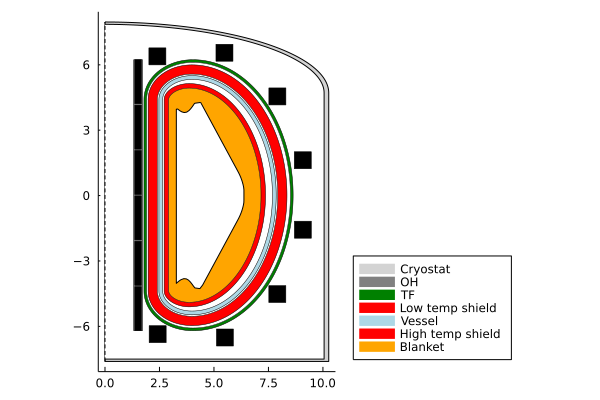

In [7]:
@everywhere function workflow_custom(dd,ini,act)
    FUSE.init(dd,ini,act)
    FUSE.ActorEquilibriumTransport(dd, act)
    FUSE.ActorHFSsizing(dd, act)
    FUSE.ActorLFSsizing(dd, act)
    FUSE.ActorCXbuild(dd, act)
    FUSE.ActorPFcoilsOpt(dd, act; optimization_scheme=:none)
    FUSE.ActorCosting(dd, act)
end

workflow_custom(dd,ini,act)
p=plot(;aspect_ratio=:equal)
plot!(p,dd.build)
plot!(p,dd.pf_active)

In [8]:
#continue_results=results
continue_results=missing
OFL=FUSE.ObjectivesFunctionsLibrary
objective_functions = [OFL[:max_fusion], OFL[:min_cost], OFL[:max_flattop]]
results=FUSE.workflow_multiobjective_optimization(workflow_custom,dd,ini,act,objective_functions;N=1000,iterations=100,continue_results=continue_results);

using Metaheuristics

X=[]
F=[]
PX=[]
PF=[]
for res in results.state.convergence
    x=transpose(hcat([res.population[k].x for k in 1:length(res.population)]...))
    f=transpose(hcat([res.population[k].f for k in 1:length(res.population)]...))
    f = hcat([objective_functions[k].(f[:,k]) for k in 1:length(objective_functions)]...)

    psol=Metaheuristics.get_non_dominated_solutions(res.population)
    px=transpose(hcat([psol[k].x for k in 1:length(psol)]...))
    pf=transpose(hcat([psol[k].f for k in 1:length(psol)]...))
    pf = hcat([objective_functions[k].(pf[:,k]) for k in 1:length(objective_functions)]...)

    push!(X,x)
    push!(F,f)
    push!(PX,px)
    push!(PF,pf)
end

using JLD2
JLD2.jldsave("FUSEMOOP.jld2";X,F,PX,PF)

Running on 121 processes
== Actuators ==
ec.power_launched
- units: W
- description: EC launched power
- value: 4.5e7
- base: 4.5e7
- default: missing
- lower: 3.0e7
- upper: 1.0e8
core_profiles.zeff
- units: 
- description: Effective ion charge
- value: 1.1
- base: 1.1
- default: missing
- lower: 1.1
- upper: 2.5
core_profiles.greenwald_fraction
- units: 
- description: Greenwald fraction, ne_vol / ne_gw
- value: 0.9
- base: 0.9
- default: missing
- lower: 0.8
- upper: 0.95

== Objectives ==
max_fusion [MW]
min_cost [$M]
max_flattop [hours]



Iteration 100%|████████████████████████████| Time: 2:08:17 (76.98  s/it)


7772.931654 seconds (1.46 G allocations: 86.351 GiB, 0.37% gc time, 0.17% compilation time)


LoadError: ArgumentError: Package JLD2 not found in current path:
- Run `import Pkg; Pkg.add("JLD2")` to install the JLD2 package.


In [40]:
Pkg.add("JLD2")
using JLD2
JLD2.jldsave("FUSEMOOP.jld2";X,F,PX,PF)

   Resolving package versions...
  No Changes to `~/.julia/dev/FUSE/Project.toml`
  No Changes to `~/.julia/dev/FUSE/Manifest.toml`


In [37]:
gr();

In [ ]:
n_color=3
opt=FUSE.opt_parameters(ini)
display(opt[n_color].description)


function objective_label(objective_functions,k,units="")
    txt = split(string(objective_functions[k].name),"_")[2]
    if length(units) > 0
        txt *= " [$units]"
    else length(objective_functions[k].units) > 0
        txt *= " [$(objective_functions[k].units)]"
    end
    return txt
end

p=plot()
for (kk,(px,pf)) in enumerate(zip(X,F))
#     if kk<(length(F))
#         continue
#     end
    scatter!(p, pf[:,1],pf[:,2],log10.(pf[:,3]),
        xlabel=objective_label(objective_functions,1),
        ylabel=objective_label(objective_functions,2),
        zlabel=(objective_label(objective_functions,3,"log₁₀(hours)")),
        marker_z=px[:,n_color],
        colorbar_title="\n\n\n"*opt[n_color].description,
        label="",
        par=(:MAP_ANNOT_OFFSET, "100p"))#,zlim=[0,1E4])
end
display(p)



# p=plot()
# for (px,pf) in zip(PX,PF)
#     scatter!(p, px[:,1],px[:,2],px[:,3],xlabel=opt[1].description,ylabel=opt[2].description,zlabel=opt[3].description,marker_z=log10.(pf[:,3]),label="")
# end
# display(p)

In [8]:
asdada
#plotlyjs();

@recipe function plot_MultiobjectiveOptimizationResults(results::MultiobjectiveOptimizationResults; index=-1)

    if index===missing
        states = results.state.convergence
    elseif index == -1
        states = [results.state]
    else 
        states = results.state.convergence[index]
    end

    X=[]
    F=[]
    PX=[]
    PF=[]
    for res in results.state.convergence
        x=transpose(hcat([res.population[k].x for k in 1:length(res.population)]...))
        f=transpose(hcat([res.population[k].f for k in 1:length(res.population)]...))
        f = hcat([objective_functions[k].(f[:,k]) for k in 1:length(objective_functions)]...)

        psol=Metaheuristics.get_non_dominated_solutions(res.population)
        px=transpose(hcat([psol[k].x for k in 1:length(psol)]...))
        pf=transpose(hcat([psol[k].f for k in 1:length(psol)]...))
        pf = hcat([objective_functions[k].(pf[:,k]) for k in 1:length(objective_functions)]...)

        push!(X,x)
        push!(F,f)
        push!(PX,px)
        push!(PF,pf)
    end

    p=plot()
    for (px,pf) in zip(PX,PF)
        scatter!(p, pf[:,1],pf[:,2],pf[:,3],xlabel=objective_functions[1].name,ylabel=objective_functions[2].name,zlabel=objective_functions[3].name,marker_z=px[:,3],label="")
    end
    display(p)

    opt=FUSE.opt_parameters(ini)
    p=plot()
    for (px,pf) in zip(PX,PF)
        scatter!(p, px[:,1],px[:,2],px[:,3],xlabel=opt[1].description,ylabel=opt[2].description,zlabel=opt[3].description,marker_z=log10.(pf[:,3]),label="")
    end
    display(p)
end


LoadError: UndefVarError: asdada not defined

In [9]:
using TGLFNN
TGLFNN.BSON.bson("test.bson",results)


LoadError: UndefVarError: results not defined